### Initialized word vector with pretrain japanese word2vec 

https://github.com/Kyubyong/wordvectors

In [1]:
word_vectors = "-word2vec"

In [2]:
#import cPickle (python2.7)
#http://testpy.hatenablog.com/entry/2017/03/17/000626
import _pickle as cPickle

import numpy as np
from collections import defaultdict, OrderedDict

import re
import sys
import time

In [3]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torch.autograd import Variable

import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

In [4]:
# Hyper parameters
num_epochs = 10
num_classes = 3
batch_size = 50
learning_rate = 0.001

### Load pickle data

In [5]:
# the pickle file contains [revs, W, W2, word_idx_map, vocab] # W2 random vectors
x = cPickle.load(open("tweet.p","rb"), encoding="latin1") # Add encoding="latin1" because got UnicodeDecodeError

### Dataset content
Get data from twitter (reference: http://tech.wonderpla.net/entry/2017/10/10/110000)
- Label 0
    - KEYWORD = "芸能 OR アニメ OR 漫画 OR ドラマ OR ゲーム"            #エンタメ系のキーワード
    - CLASS_LABEL = "\__label__0"

- Label 1
    - KEYWORD = "美容 OR サロン OR エステ OR 化粧 OR 保湿"            #美容系のキーワード
    - CLASS_LABEL = "\__label__1"

- Label 2
    - KEYWORD = "日常 OR 料理 OR 家事 OR 収納 OR 家具"            #暮らし系のキーワード
    - CLASS_LABEL = "\__label__2"

#### See data sample

In [6]:
df = pd.DataFrame(x[0])

# label 0: Entertainment 
df[df['y'] == 0].sample(2)

,num_words,split,text,y
543,26,2,アサデス 。 6 時 台 相 葉 雅紀 10 月 期 スタート 金曜 ナイト ドラマ 「 僕...,0
383,55,6,森田 童子 さん 死去 ドラマ 「 高校 教師 」 の 主題歌 で 話題 （ 朝日新聞 ...,0


In [7]:
# label 1 : Beauty
df[df['y'] == 1].sample(2)

,num_words,split,text,y
989,37,9,＼ フォロー プレゼント ／ 初夏 の 美容 特集 番外 編 ️ 疲れ やすい 、 眠れ な...,1
679,13,2,インターネット 囲碁 サロン オンライン 対極 # 囲碁 # 対極 # オンライン # イン...,1


In [8]:
# label 2: Life
df[df['y'] == 2].sample(2)

,num_words,split,text,y
1769,58,9,万引き 家族 、 貧しい 家 は 物 が 多く ゴチャゴチャ し て い て 、 裕福 な ...,2
1546,16,0,日常 生活 に は 支障 ない ん だ けど な 〜 〜 〜 作業 が 辛い,2


In [9]:
revs, W, W2, word_idx_map, vocab = x[0], x[1], x[2], x[3], x[4]

In [10]:
# Get the number of the longest sentence
max_l = np.max(pd.DataFrame(revs)["num_words"])
print("max sentence length: ", max_l)

max sentence length:  100


In [11]:
print('revs',len(x[0])) # number of sentence
print('W', len(x[1])) # W are pretrained word vectors (unknown words are randomly initialized)
print('W2', len(x[2])) # W2 are randomly initialized vectors
print('word_idx_map', len(x[3]))
print('vocab', len(x[4]))

revs 1772
W 9468
W2 9468
word_idx_map 9467
vocab 9467


In [12]:
revs[1]

{'y': 0,
 'text': 'え 、 サラリーマン し ながら 、 商業 漫画 の 仕事 を し て 、 ツイッター に 定期 的 に 漫画 を あげ て 、 さらに コミケ の 原稿 を 作る ！ ？',
 'num_words': 32,
 'split': 2}

In [13]:
if word_vectors=="-rand":
    print("using: random vectors")
    U = W2
elif word_vectors=="-word2vec":
    print("using: word2vec vectors")
    U = W

using: word2vec vectors


In [14]:
U.shape

(9468, 300)

### Make dataset (check original code)
make each sentence an word index map using word_idx_map

In [15]:
def get_idx_from_sent(sent, word_idx_map, max_l=51, k=300, filter_h=5):
    """
    Transforms sentence into a list of indices. Pad with zeroes.
    """
    x = []
    pad = filter_h - 1
    for i in range(pad):
        x.append(0)
    words = sent.split()
    for word in words:
        if word in word_idx_map:
            x.append(word_idx_map[word])
    while len(x) < max_l + 2*pad:
        x.append(0)
    return x

def make_idx_data_cv(revs, word_idx_map, cv, max_l=51, k=300, filter_h=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    train, test = [], []
    for rev in revs:
        sent = get_idx_from_sent(rev["text"], word_idx_map, max_l, k, filter_h) # one sentence
        sent.append(rev["y"])
        if rev["split"]== cv:  # "split" is random number of np.random.randint(0,10)
            test.append(sent)        
        else:  
            train.append(sent)   
    train = np.array(train, dtype="int")
    test = np.array(test, dtype="int")
    return [train, test] 

In [16]:
i = 0
datasets = make_idx_data_cv(revs, word_idx_map, i, max_l, k=300, filter_h=5)

#### Example of sentence to word index map

In [17]:
revs[1]

{'y': 0,
 'text': 'え 、 サラリーマン し ながら 、 商業 漫画 の 仕事 を し て 、 ツイッター に 定期 的 に 漫画 を あげ て 、 さらに コミケ の 原稿 を 作る ！ ？',
 'num_words': 32,
 'split': 2}

In [18]:
print(len(datasets[0][0]))
datasets[0][1] # sentence => word index map padding with zeros

109


array([   0,    0,    0,    0,   23, 3829,   22,   15,   28, 3829,   30,
       3833,   21, 3845,   29,   15,    2, 3829,   31,    7,   24,   25,
          7, 3833,   29, 3842,    2, 3829,   32,   26,   21,   27,   29,
       3841, 3843, 3844,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0])

In [19]:
print('train data size:', datasets[0].shape)
print('test data size:', datasets[1].shape)

train data size: (1620, 109)
test data size: (152, 109)


### Make dataset (using vectors)

In [20]:
def get_idx_from_sent_2vec(sent, U, word_idx_map, max_l=51, k=300, filter_h=5):
    """
    Transforms sentence into a list of indices. Pad with zeroes.
    """
    pad = filter_h - 1
    x = np.zeros((max_l+2*pad, k))

    words = sent.split()
    # starting after padding
    i = pad
    for word in words:
        if word in word_idx_map:
            x[i] = U[word_idx_map[word]]
            i += 1
    return x

def make_idx_data_cv_2vec(revs, U, word_idx_map, cv, max_l=51, k=300, filter_h=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    train_image, train_label = [], []
    test_image, test_label = [], []
    test_rev = []
    for rev in revs:
        sent = get_idx_from_sent_2vec(rev["text"], U, word_idx_map, max_l, k, filter_h) # one sentence
        if rev["split"] == cv:  # "split" is random number of np.random.randint(0,10)
            test_image.append(sent) 
            test_label.append(rev["y"])
            test_rev.append(rev)
        else:  
            train_image.append(sent)
            train_label.append(rev["y"])
    train_image = np.array(train_image)
    train_label = np.array(train_label)
    test_image = np.array(test_image)
    test_label = np.array(test_label)
    test_rev = np.array(test_rev)
    return (train_image, train_label), (test_image, test_label, test_rev)

In [21]:
t = "effective but too tepid biopic"
t_sent_2vec = get_idx_from_sent_2vec(t, U, word_idx_map, max_l, k=300, filter_h=5)
print("sentence length(before)", len(t_sent_2vec)) # max_l(51)+2*pad(filter_h-1)

sentence length(before) 108


In [22]:
t_sent_2vec[0].shape

(300,)

In [23]:
i = 0
datasets_2vec = make_idx_data_cv_2vec(revs, U, word_idx_map, i, max_l, k=300, filter_h=5)

In [24]:
(train_image, train_label), (test_image, test_label, test_rev) = datasets_2vec

#### Example of sentence to vector

In [25]:
revs[1]

{'y': 0,
 'text': 'え 、 サラリーマン し ながら 、 商業 漫画 の 仕事 を し て 、 ツイッター に 定期 的 に 漫画 を あげ て 、 さらに コミケ の 原稿 を 作る ！ ？',
 'num_words': 32,
 'split': 2}

In [26]:
p2 = pd.DataFrame(train_image[1])
print(p2.shape)
p2.head(10)

(108, 300)


,0,1,2,3,4,5,6,7,8,9,...,290,291,292,293,294,295,296,297,298,299
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
1,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
4,-0.014600,0.031418,0.090312,-0.000052,-0.013168,-0.069336,0.095244,-0.012322,-0.057443,-0.061566,...,-0.053096,-0.027628,-0.046655,0.011596,0.024088,0.015511,-0.029644,0.006272,-0.025874,-0.076605
5,-0.100688,-0.034349,-0.015562,0.102048,-0.034377,-0.029769,-0.074679,0.027827,0.039846,0.077095,...,-0.050505,-0.074465,0.032439,-0.052896,0.089773,-0.094414,-0.032414,0.082769,-0.039997,0.041615
6,-0.015008,0.014014,0.043544,-0.039249,0.007010,0.022439,0.013127,-0.034857,0.049377,-0.051198,...,0.071647,0.033772,0.089638,0.014955,0.064228,0.010969,-0.009657,-0.045884,0.019352,0.165582
7,-0.119047,0.027210,0.002545,0.006658,-0.011127,0.037048,0.062418,-0.032071,-0.007870,-0.047811,...,0.006505,0.060982,-0.125483,0.103325,0.026611,0.054767,-0.005485,-0.085803,0.017624,-0.100847
8,-0.021471,0.029862,-0.038230,-0.037036,-0.000850,0.018548,0.075258,0.027883,0.055498,0.012769,...,0.007132,0.028085,-0.053919,0.025820,0.005494,0.030930,0.052201,0.046751,0.104778,0.004859
9,-0.100688,-0.034349,-0.015562,0.102048,-0.034377,-0.029769,-0.074679,0.027827,0.039846,0.077095,...,-0.050505,-0.074465,0.032439,-0.052896,0.089773,-0.094414,-0.032414,0.082769,-0.039997,0.041615


### Make dataset iterable

In [27]:
t_image = torch.FloatTensor(train_image).reshape(-1, 1, max_l + 2 * (5-1), 300)
t_label = torch.LongTensor(train_label)
train_dataset = list(zip(t_image, t_label))
len(train_dataset)

1620

In [28]:
# Data loader
train_loader = torch.utils.data.DataLoader(dataset=train_dataset,
                                           batch_size=batch_size, 
                                           shuffle=True)


In [29]:
for images, labels in train_loader:
    print('images:', images.shape, '\nlabels:', labels.shape)
    print(images[1][0])
    print(labels[1])
    break

images: torch.Size([50, 1, 108, 300]) 
labels: torch.Size([50])
tensor([[ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000],
        [ 0.0000,  0.0000,  0.0000,  ...,  0.0000,  0.0000,  0.0000]])
tensor(1)


In [30]:
c_image = torch.FloatTensor(test_image).reshape(-1, 1, max_l + 2 * (5-1), 300)
c_label = torch.LongTensor(test_label)
test_dataset = list(zip(c_image, c_label, test_rev))
len(test_dataset)

152

In [31]:
# Data loader
test_loader = torch.utils.data.DataLoader(dataset=test_dataset,
                                           batch_size=batch_size, 
                                           shuffle=False)


### Model parameters (original code)

In [32]:
filter_hs=[3, 4, 5]
hidden_units=[100, num_classes]
batch_size=50
img_w=300
img_h = len(datasets[0][0])-1  # sentence length (subtracted 1 for y label)

filter_w = img_w    
feature_maps = hidden_units[0]
filter_shapes = []
pool_sizes = []
for filter_h in filter_hs:
    filter_shapes.append((feature_maps, 1, filter_h, filter_w))
    pool_sizes.append((img_h-filter_h+1, img_w-filter_w+1))


In [33]:
print(filter_shapes)
image_shape = (batch_size, 1, img_h, img_w)
print('one batch train', image_shape)
print(pool_sizes)

[(100, 1, 3, 300), (100, 1, 4, 300), (100, 1, 5, 300)]
one batch train (50, 1, 108, 300)
[(106, 1), (105, 1), (104, 1)]


### Padding & Stride
- Output size

    $ O = \frac {W-K+2P}{S} + 1 $
    - O: output h/w
    - W: input h/w
    - K: filter size(kernel size)
    - P: padding
        - $  P = \frac {K-1}{2} $
    - S: stride

### Network

- Theano:
    - conv_layer: LeNetConvPoolLayer
    - classifier: MLPDropout

### Model:


```
Network
Input ->
Conv -> ReLU -> MaxPool |
Conv -> ReLU -> MaxPool | -> concat
Conv -> ReLU -> MaxPool |
Fully Connected Layer(Logits -> Softmax) -> Labels
```

```
Convolutional layer formula:
- Filter 1(Kernel) size K = 3 => (3 x 300)
- P(same padding) P = (3-1)/2=1
- S(stride) S = 1
- in_channels = 1
- out_channels (int) – Number of channels produced by the convolution = 100
Pooling layer formula:
- K
```

```
*Filter dimensions*:
Conv1 (W_conv, (100, 1, 3, 300))
Conv1 (b_conv, (100,))
Conv2 (W_conv, (100, 1, 4, 300))
Conv2 (b_conv, (100,))
Conv3 (W_conv, (100, 1, 5, 300))
Conv3 (b_conv, (100,))

*Layer input dimensions*:
- Input image(64, 300) 

----------------------------------------------------------------------
|  Conv1  (100, 3, 300)   Conv2  (100, 4, 300)   Conv3  (100, 5, 300) |
|  MaxPool (100, 62, 1)   MaxPool (100, 61, 1)   MaxPool (100, 60, 1) |
-----------------------------Concat ----------------------------------

- Concatenated (100, 1, 1) + (100, 1, 1) + (100, 1, 1) => (300, 1, 1) 

- Fully Connected Layer(Logits (100, 1) -> Logits (2, 1) -> Softmax) -> Labels
```

In [34]:
class ConvPoolLayer(nn.Module):
    def __init__(self, num_classes=2):
        super(ConvPoolLayer, self).__init__()

        # Layer 1: conv - relu - conv- relu - pool
        self.ngram1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=feature_maps, kernel_size=(filter_hs[0], img_w), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_sizes[0], stride=None))
        self.ngram2 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=feature_maps, kernel_size=(filter_hs[1], img_w), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_sizes[1], stride=None))
        self.ngram3 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=feature_maps, kernel_size=(filter_hs[2], img_w), stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=pool_sizes[2], stride=None))
        
        # Fully Connected 1 (readout)
        self.fc = nn.Sequential(
            nn.Linear(feature_maps * 3, hidden_units[0]),
            nn.ReLU(),
            nn.Linear(hidden_units[0], num_classes))

        # Initialize all parameters using kaiming normalization
        self.init_weights_kaiming()
    
    def init_weights_kaiming(self):
        #Use kaiming normalization to initialize the parameters
        for layer in [self.ngram1, self.ngram2, self.ngram3, self.fc]:
            for m in layer:
                if type(m) == nn.Conv2d or type(m) == nn.Linear:
                    m.weight = nn.init.kaiming_normal_(m.weight)

    def forward(self, x):

        out1 = self.ngram1(x)
        out2 = self.ngram2(x)
        out3 = self.ngram3(x)
        out = torch.cat((out1, out2, out3), 1)
        
        out = out.view(out.size(0), -1)
    
        # Linear function (readout)
        out = self.fc(out)
        
        return out

In [35]:
model = ConvPoolLayer(num_classes)
print(model)

ConvPoolLayer(
  (ngram1): Sequential(
    (0): Conv2d(1, 100, kernel_size=(3, 300), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(106, 1), stride=(106, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (ngram2): Sequential(
    (0): Conv2d(1, 100, kernel_size=(4, 300), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(105, 1), stride=(105, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (ngram3): Sequential(
    (0): Conv2d(1, 100, kernel_size=(5, 300), stride=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=(104, 1), stride=(104, 1), padding=0, dilation=1, ceil_mode=False)
  )
  (fc): Sequential(
    (0): Linear(in_features=300, out_features=100, bias=True)
    (1): ReLU()
    (2): Linear(in_features=100, out_features=3, bias=True)
  )
)


In [36]:
criterion = nn.CrossEntropyLoss()

In [37]:
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

In [38]:
for p in model.parameters():
    print(p.shape)

torch.Size([100, 1, 3, 300])
torch.Size([100])
torch.Size([100, 1, 4, 300])
torch.Size([100])
torch.Size([100, 1, 5, 300])
torch.Size([100])
torch.Size([100, 300])
torch.Size([100])
torch.Size([3, 100])
torch.Size([3])


### Train model

In [39]:
avg_losses = list()
iter = 0

for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):
        total_loss = list()
        
        # Load images as Variable
        images = Variable(images) # Now we dont need to resize like images.view(xx)
        labels = Variable(labels)
        
        # Clear gradients w.r.t parameters
        optimizer.zero_grad()
        
        # Forward pass to get output/logits
        outputs = model(images)
        
        # Calculate Loss: Softmax --> cross entropy loss
        loss = criterion(outputs, labels)
        
        # Getting gradients w.r.t paramters
        loss.backward()
        
        # Track loss to plot the result
        total_loss.append(loss.item())
        
        # Updating parameters
        optimizer.step()
        
        iter += 1
        
        if iter % 50 == 0:
            # Print Loss
            print('Iteration: {}. Loss: {}.'.format(iter, loss.item()))
            avg_loss = np.divide(np.sum(total_loss), len(total_loss))
            avg_losses.append(avg_loss)

Iteration: 50. Loss: 0.20684829354286194.
Iteration: 100. Loss: 0.011857990175485611.
Iteration: 150. Loss: 0.007408613339066505.
Iteration: 200. Loss: 0.0022772180382162333.
Iteration: 250. Loss: 0.0014816458569839597.
Iteration: 300. Loss: 0.0012197201140224934.


### Plot the loss vs iteration

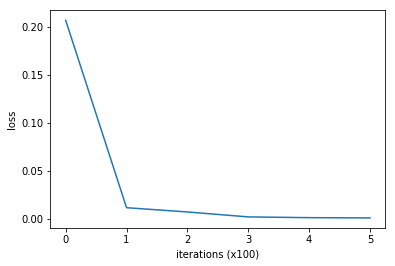

In [40]:
x_axis = np.arange(len(avg_losses))
plt.plot(x_axis, avg_losses, label='train')
plt.xlabel('iterations (x100)')
plt.ylabel('loss')
plt.show()

### Test model with test dataset

In [41]:
n_test = len(test_loader) * batch_size
wrong_predictions = []

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels, revs in test_loader:
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        # See which are error predictions
        result = (predicted == labels)
        err_imgs = images[result == 0] # 0 means wrong prediction
        err_labels = labels[result == 0]
        err_p = outputs[result == 0]
        err_outputs = predicted[result == 0]
        err_texts = np.array(revs['text'])[np.array((result == 0).numpy(), dtype=np.bool)]
        for img, lbl, p, out, text in zip(err_imgs, err_labels, err_p, err_outputs, err_texts):
            wrong_predictions.append((img, lbl, p, out, text))
     
    print('Test Accuracy of the model on the {} test images: {} %'.format(n_test, 100 * correct / total))

Test Accuracy of the model on the 200 test images: 99.34210526315789 %


In [42]:
label_names = ['エンタメ系', '美容系', '暮らし系']
# unpack img, lbl, out, text
for img, lbl, p, out, text in wrong_predictions:
    print('True label: ', lbl.item(), '\t', label_names[lbl.item()])
    print('Predition: ', out.item(), '\t', label_names[out.item()])
    print('Possibility:', p)
    print(text, '\n')
    

True label:  2 	 暮らし系
Predition:  0 	 エンタメ系
Possibility: tensor([ 4.0938, -2.3852, -1.6469])
だいたい ３ ０ ０ ０ 円 前後 な の か な ・ ・ ・ カード ゲーム 全然 やっ て ない から プレイマット って どういう 風 に 収納 し たり する の か わかっ て ない けど 折りたたん じゃう の か な ？ それとも 巻物 みたい に クルクル 巻く の か な ・ ・ ・ 



### Test model with train dataset

In [43]:
n_train = len(train_loader) * batch_size

model.eval()
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in train_loader:
        images = Variable(images)
        labels = Variable(labels)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
    print('Test Accuracy of the model on the {} train images: {} %'.format(n_train, 100 * correct / total))

Test Accuracy of the model on the 1650 train images: 100.0 %


### Predict single inputted text

#### Input the text to predict (change the text below)

In [44]:
# text_to_predict = "お風呂掃除でいつも落ちなかった溝にある黒カビが家事えもんの塩素系漂白剤＋片栗粉でほぼ真っ白になって感動 家事えもんのテクニック凄い～！"

text_to_predict = "コスメの最安値が見つけられるアプリ💄💋メイク動画とか 美容情報も載ってるし最高😆🙌📲http://goo.gl/K5Fmea 女子にはほんとに助かる〜💗"

In [45]:
import sys, os
sys.path.append(os.pardir)
from process_data import build_single_data_cv

loading data...
data loaded!
number of sentences: 1772
vocab size: 9467
max sentence length: 100
loading word2vec vectors...


In [46]:
def single_make_idx_data_cv_2vec(revs, U, word_idx_map, max_l=51, k=300, filter_h=5):
    """
    Transforms sentences into a 2-d matrix.
    """
    test_image, test_label = [], []
    test_rev = []
    for rev in revs:
        sent = get_idx_from_sent_2vec(rev["text"], U, word_idx_map, max_l, k, filter_h) # one sentence
        test_image.append(sent) 
        test_label.append(rev["y"])
        test_rev.append(rev)

    test_image = np.array(test_image)
    test_label = np.array(test_label)
    test_rev = np.array(test_rev)
    return test_image, test_label, test_rev

In [47]:
single_revs, _ = build_single_data_cv(text_to_predict)
single_data_2vec = single_make_idx_data_cv_2vec(single_revs, U, word_idx_map, max_l, k=300, filter_h=5)

1行処理済み


In [48]:
model.eval()
with torch.no_grad():
    images, labels, revs = single_data_2vec
    images = Variable(torch.Tensor(images.reshape(1, 1, -1, 300)))
    outputs = model(images)
    _, predicted = torch.max(outputs.data, 1)
    print('Prediction:', predicted.item(), label_names[predicted.item()])
    print('Text:', revs[0]['text'])

Prediction: 1 美容系
Text: コスメ の 最 安値 が 見つけ られる アプリメイク 動画 とか 美容 情報 も 載っ てる し 最高 女子 に は ほんとに 助かる 〜
